## This notebook visualizes the resutls of "Replay_analysis.ipynb"  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.special import factorial
from scipy.stats import spearmanr
import pftools as pf
import configparser
import os
import matplotlib as mpl
# Initialize the configuration parser
config = configparser.ConfigParser()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Read the configuration file
config.read('config.ini')

# Get the data folder path from the config file
savefolder= config['paths']['savefolder']
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 16  # You can adjust the font size as needed
import mtools as mot
import pickle
from scipy.stats import mode
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

# Calculating the p-values for the given z-scores
from scipy import stats
from scipy.stats import wilcoxon

Illustration of the use of these functions
 Mask indexes (burst array indexes): 
 [2, 10, 50] 
Mask indexes expanded to its 2 neighbours: 
 [ 0  1  2  3  4  8  9 10 11 12 48 49 50 51 52] 
Input indexes (array indexes of the positions y or spike positions ysp)
 [3, 7, 12, 30, 51, 100] 
Input indexes excluding those in the set of mask indexes
 [  7  30 100]


In [2]:

plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [3]:
phase='learning'
chosen_cell_type='all'


In [4]:
# In this code i load the data from outward runs and find the cells which are place cells.
#burst_len='200ms'
fol='485'
#dir_of_run='L'
#celltype='PC'
celltype='Alltest_neworder'
fs = 20# sampling freq
burst_length=0.5
burst_len=str(burst_length)+'s'
burstsize=burst_length*fs# sample numbers of a burst

In [5]:
#filename = fol+'outward_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'
filename = fol+'sampling_L sampling_R outward_L outward_R reward_L reward_R_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'# load all at once reward outward sampling

#filename_reward = fol+'reward_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'
#filename_sampling = fol+'sampling_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'

#filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

data = np.load(join(savefolder, filename), allow_pickle=True)
#data_reward = np.load(join(savefolder, filename_reward), allow_pickle=True)
#data_sampling = np.load(join(savefolder, filename_sampling), allow_pickle=True)

bound = [0, data['lin_pos'].shape[0]] #if turn_type == 'left' else [sepidx, endind]  

target_cluids=np.unique(data['ids_clust'])

In [6]:
Cell_types=np.load( savefolder+'_Cell_types',allow_pickle=True)
Cluster_types=np.load( savefolder+'_Cluster_types',allow_pickle=True)

TC_clusters=np.concatenate((Cluster_types[phase][fol]['TC_arm'],Cluster_types[phase][fol]['TC_stem']))
PC_clusters=np.concatenate((Cluster_types[phase][fol]['PC_arm'],Cluster_types[phase][fol]['PC_stem']))


In [7]:
all_cluster=np.unique(data['ids_clust'])

all_cluster_tc_removed = np.setdiff1d(all_cluster, TC_clusters)
SI_clusters = np.setdiff1d(all_cluster_tc_removed, PC_clusters)

cluster_types={}
cluster_types['TC_cluster']=TC_clusters
cluster_types['PC_cluster']=PC_clusters
cluster_types['Non_SI_cluster']=SI_clusters



In [8]:

Nshuffles = 500
# Cell type and condition names
#cell_types = ['TC_cells', 'PC_cells', 'Non_SI_cells','All']
cond_names = {
    'sampling_L': 0,
    'sampling_R': 1,
    'outward_L': 2,
    'outward_R': 3,
    'reward_L': 4,
    'reward_R': 5,
    'inward_L': 6,
    'inward_R': 7
}

In [9]:

plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [10]:
# load data of Replay_Analysis and visualize the resutls

replay_stats={'learning':{},'learned':{}}
animal_list=['478','481','483','485']
animal_sig_burst_ratio_phase={}
for phase in ['learning','learned',]:
    animal_sig_burst_ratio={}
    for aniaml in animal_list:
        #for dir in ['L','R']:
        #for cond in conditions_to_filter:
            
            namefile='Replay'+aniaml+phase
            file2load=savefolder+namefile
            
            replay_stats[phase][aniaml]=np.load(file2load,allow_pickle=True)

            sig_ratios=replay_stats[phase][aniaml]
            animal_sig_burst_ratio[aniaml]=[(cluster,side,metric,sig_ratios[cluster][side][metric][ 'sig_burst_ratio']) for cluster in sig_ratios for side in ['left','right'] for metric in ['sampling_L', 'sampling_R', 'outward_L', 'outward_R', 'reward_L', 'reward_R']]
    animal_sig_burst_ratio_phase[phase]=animal_sig_burst_ratio

In [11]:
#pvals_pos=[(cluster,side,metric,sig_ratios[cluster][side][metric][ 'pvals_pos']) for cluster in sig_ratios for side in ['left','right'] for metric in ['sampling_L', 'sampling_R', 'outward_L', 'outward_R', 'reward_L', 'reward_R']]

In [12]:
import numpy as np
from scipy.stats import mannwhitneyu

# Step 1: Initialize Rmse dictionary
Rmse = {}

for phase in replay_stats.keys():
    if phase == 'learned':
        for anm in replay_stats[phase].keys():
            for cl_typ in replay_stats[phase][anm].keys():
                for sid in replay_stats[phase][anm][cl_typ].keys():
                    for tsk in replay_stats[phase][anm][cl_typ][sid].keys():
                        # Skip 'inward' task
                        if 'inward' in tsk:
                            continue
                        # Initialize the dictionary for the task and cluster type
                        if cl_typ not in Rmse:
                            Rmse[cl_typ] = {}
                        if tsk not in Rmse[cl_typ]:
                            Rmse[cl_typ][tsk] = []
                        
                        # Add RMSE values to the corresponding task and cluster type
                        Rmse[cl_typ][tsk].extend(replay_stats[phase][anm][cl_typ][sid][tsk]['rmse'])

# Step 2: Merge `_L` and `_R` tasks within each cluster type
merged_Rmse = {}

for cl_typ in Rmse.keys():
    merged_Rmse[cl_typ] = {}
    tasks = list(Rmse[cl_typ].keys())
    
    for tsk in tasks:
        # Identify corresponding "_R" task for each "_L"
        if tsk.endswith('_L'):
            tsk_right = tsk.replace('_L', '_R')
            if tsk_right in tasks:
                # Merge `_L` and `_R`
                merged_Rmse[cl_typ][tsk.replace('_L', '')] = Rmse[cl_typ][tsk] + Rmse[cl_typ][tsk_right]

# Step 3: Merge data across cluster types for each task
merged_tasks_across_clusters = {}

for cl_typ, tasks in merged_Rmse.items():
    for tsk, values in tasks.items():
        if tsk not in merged_tasks_across_clusters:
            merged_tasks_across_clusters[tsk] = []
        merged_tasks_across_clusters[tsk].extend(values)

# Step 4: Perform pairwise statistical tests between tasks
task_keys = list(merged_tasks_across_clusters.keys())
p_values_across_clusters = {}

for i in range(len(task_keys)):
    for j in range(i + 1, len(task_keys)):
        tsk1, tsk2 = task_keys[i], task_keys[j]
        # Perform Mann-Whitney U test
        p_values_across_clusters[f"{tsk1} vs {tsk2}"] = mannwhitneyu(
            merged_tasks_across_clusters[tsk1], merged_tasks_across_clusters[tsk2]
        )

# Step 5: Output Results
print("Merged RMSE Data Across Cluster Types:")
for task, data in merged_tasks_across_clusters.items():
    print(f"{task}: {data}")

print("\nPairwise Statistical Tests (Mann-Whitney U):")
for comparison, result in p_values_across_clusters.items():
    print(f"{comparison}: Statistic={result.statistic}, P-value={result.pvalue}")


Merged RMSE Data Across Cluster Types:
sampling: [0.24529805564669685, 0.3752842598457601, 0.2712832262937032, 0.403489914339049, 0.3940494892776795, 0.4841868005997779, 0.3303267742369332, 0.1808466200955937, 0.29910463188851094, 0.22378995330226342, 0.22657739849858155, 0.27173095938025593, 0.26049152596646374, 0.17379106229416214, 0.4228871760106591, 0.5821256614462943, 0.4066501503645938, 0.39912871646140835, 0.41142715689454096, 0.37343140478926695, 0.4289874970054368, 0.4181695786375173, 0.31785385231738195, 0.406239098883308, 0.4157309827280137, 0.44435693068416593, 0.38735972371370203, 0.2939744886890698, 0.41628890789079376, 0.44877371033355257, 0.31349963516811713, 0.30098481214648876, 0.34043337174056554, 0.38775658171933935, 0.42741062527667645, 0.5971576724067822, 0.46831202105648795, 0.36225367293545124, 0.27363902829051723, 0.3981401609498538, 0.5405231564591916, 0.4219091619522908, 0.37874315045421564, 0.3064589876494262, 0.4845697045964809, 0.17682612261219385, 0.43594

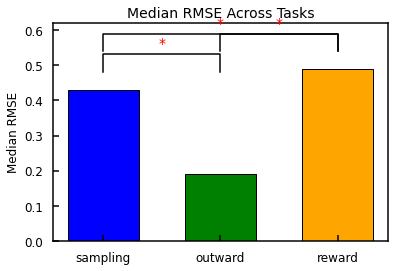

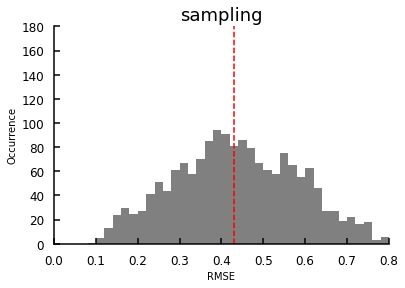

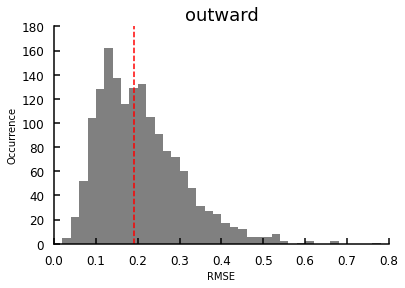

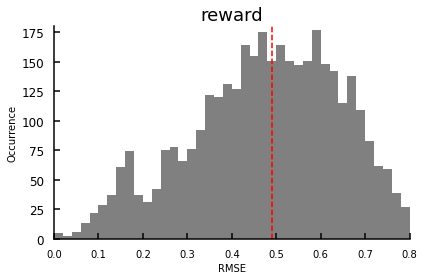

In [13]:
import matplotlib.pyplot as plt

# Step 1: Compute medians for each task
task_medians = {task: np.median(values) for task, values in merged_tasks_across_clusters.items()}

# Step 2: Prepare data for plotting
tasks = list(task_medians.keys())
medians = [task_medians[task] for task in tasks]
colors = ['blue', 'green', 'orange']  # Assign colors for tasks

# Step 3: Plot the bar chart
fig, ax = plt.subplots(figsize=(6, 4))

# Bar chart of medians
bars = ax.bar(tasks, medians, color=colors, edgecolor='k', width=0.6)

# Add individual data points for each task
for i, task in enumerate(tasks):
    y_values = merged_tasks_across_clusters[task]
    x_positions = np.random.normal(i, 0.05, size=len(y_values))  # Add jitter for visualization
    #ax.scatter(x_positions, y_values, color='black', s=20, alpha=0.7)
    plt.figure()
    plt.hist(y_values,bins=np.arange(0,1,.02),color="gray")
    plt.vlines(np.median(y_values),0,200,color='r',linewidth=1.5,linestyle='dashed')
    plt.ylim([0,180])
    plt.xlim([0,.8])
    plt.xlabel('RMSE')
    plt.ylabel('Occurrence')
    hide_spines()

    plt.title(task)
    plt.savefig(savefolder+'RMSE'+task+phase+'.svg',dpi=300)

# Step 4: Add significance stars
y_offset = 0.05  # Offset for star positioning
for comparison, result in p_values_across_clusters.items():
    if result.pvalue < 0.05:  # Significant difference
        task1, task2 = comparison.split(" vs ")
        x1, x2 = tasks.index(task1), tasks.index(task2)
        y = max(medians[x1], medians[x2]) + y_offset
        ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], color='black', linewidth=1.5)  # Horizontal line
        ax.text((x1 + x2) / 2, y + y_offset + 0.02, '*', ha='center', fontsize=14, color='red')  # Star

# Step 5: Formatting
ax.set_title('Median RMSE Across Tasks', fontsize=14)
ax.set_ylabel('Median RMSE', fontsize=12)

plt.xticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()


In [15]:
#phase='learned'
combined_burst_ratios_df={}
for phase in ['learning', 'learned']:
    # Calculate percentages for all combinations
    all_percentages_tc_left = pf.calculate_all_percentages_merged(replay_stats, phase, 'TC_cluster', 'left')
    all_percentages_tc_right = pf.calculate_all_percentages_merged(replay_stats, phase, 'TC_cluster', 'right')

    all_percentages_pc_left = pf.calculate_all_percentages_merged(replay_stats, phase, 'PC_cluster', 'left')
    all_percentages_pc_right = pf.calculate_all_percentages_merged(replay_stats, phase, 'PC_cluster', 'right')

    all_percentages_non_sig_left = pf.calculate_all_percentages_merged(replay_stats, phase, 'Non_SI_cluster', 'left')
    all_percentages_non_sig_right = pf.calculate_all_percentages_merged(replay_stats, phase, 'Non_SI_cluster', 'right')

    # Combine all results into a single DataFrame for easier analysis
    combined_results = {
        'TC_left': all_percentages_tc_left,
        'TC_right': all_percentages_tc_right,
        'PC_left': all_percentages_pc_left,
        'PC_right': all_percentages_pc_right,
        'Non_SI_left': all_percentages_non_sig_left,
        'Non_SI_right': all_percentages_non_sig_right
    }

    # Convert to a DataFrame
    combined_results_df = pd.concat({k: pd.DataFrame(v).T for k, v in combined_results.items()}, axis=1)
    combined_burst_ratios_df[phase]=combined_results_df


: 

: 

c:\Users\hamed\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\hamed\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\hamed\AppData\Local\Temp\ipykernel_21884\1185619292.py:54: RuntimeWarning: invalid value encountered in true_divide
  pdf_values = counts / (np.sum(counts) * bin_width)


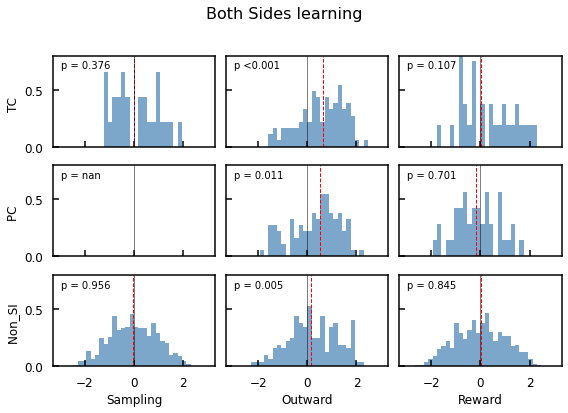

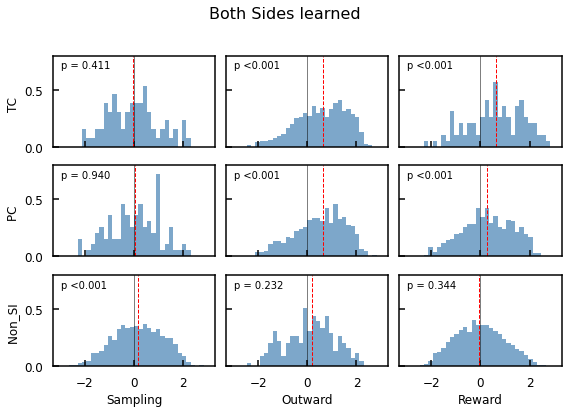

In [16]:
# get P-values of z-distributions



# Define sides (left and right) to create separate figures
sides = ['left', 'right']
contexts = ['sampling', 'outward', 'reward']
clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']

pval_all={}
#phase='learned'
# Create separate figures for left and right sides
for phase in ['learning','learned']:
    
    p_values_dict={}
    fig, axes = plt.subplots(len(clusters), len(contexts), figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle("Both Sides "+phase, fontsize=16)

    for i, cluster in enumerate(clusters):
        for j, context in enumerate(contexts):
            # Extract Z values
            z_values_l = pf.extract_z_values_by_context_cluster_side(replay_stats,phase, context, cluster, 'left')
            z_values_r = pf.extract_z_values_by_context_cluster_side(replay_stats,phase, context, cluster, 'right')
            z_values=np.concatenate((z_values_l,z_values_r))
            z_values=z_values[~np.isnan(z_values)]


            median_value = np.median(z_values)
            axes[i, j].axvline(median_value, color='r', linestyle='--', linewidth=1)
            axes[i, j].axvline(0, color='k', linewidth=.5)
            #axes[i, j].text(median_value, ax.get_ylim()[1] * 0.95, f'Median={median_value:.2f}', ha='center', color='k')

            # Perform a one-sample t-test
            if len(z_values) > 1:  # Ensure there are enough values to perform the test
                #stat, p_value = stats.ttest_1samp(z_values, 0)
                stat, p_value = wilcoxon(z_values_l)


            else:
                p_value = np.nan  # Not enough data

            # Save the p-value in the dictionary
            key = f"{context}_{cluster}"
            p_values_dict[key] = p_value

            # Step 1: Compute histogram
            # Step 1: Compute histogram
            counts, bin_edges = np.histogram(z_values, bins=np.linspace(-3, 3, 35))
            #t_stat, p_value_ttest = stats.ttest_1samp(z_values, 0)
            # Step 2: Compute bin width
            bin_width = bin_edges[1] - bin_edges[0]

            # Step 3: Normalize the counts to compute the PDF
            pdf_values = counts / (np.sum(counts) * bin_width)

            # Step 4: Compute bin centers for plotting
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Step 5: Plot the PDF as a histogram of bars
            axes[i, j].bar(bin_centers, pdf_values, width=bin_width, alpha=0.7, color='steelblue')

            # Add p-value text to the plot
            # axes[i, j].text(0.05, 0.95, f"p = {p_value:.3f}", transform=axes[i, j].transAxes, 
            #                 fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))
            if p_value < 0.001:
                p_text = f"p = {p_value:.1e}"  # Scientific notation
                p_text = f"p <0.001"  # Decimal format
            else:
                p_text = f"p = {p_value:.3f}"  # Decimal format
                


            axes[i, j].text(0.05, 0.95, p_text, transform=axes[i, j].transAxes, 
                fontsize=10, verticalalignment='top')
            axes[i, j].set_ylim([0,.8])
            # Plot the histogram
            #axes[i, j].hist(z_values, bins=np.linspace(-3,3,35),density=True, alpha=0.7, edgecolor='black', color='steelblue')
            #axes[i, j].set_title(f"{context.capitalize()}", fontsize=10)
            axes[i, 0].set_ylabel(f"{cluster.replace('_cluster', ' ')}", fontsize=12)

            axes[2, j].set_xlabel(f"{context.capitalize()}", fontsize=12)

            
            #axes[i, j].grid(True)

            # axes[i, j].set_ylim([0,500])
        # Add common labels
        #fig.text(0.5, 0.04, 'Context', ha='center', fontsize=14)
        #fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

    pval_all[phase]=p_values_dict
    plt.savefig(savefolder+'Distribution_z_score_bursts'+phase+'.svg')
        # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

C:\Users\hamed\AppData\Local\Temp\ipykernel_21884\1029522901.py:39: RuntimeWarning: invalid value encountered in true_divide
  pdf_values = counts / (np.sum(counts) * bin_width)



Results for phase: learning
                             stat       p_value    n
sampling_TC_cluster         158.0  6.567067e-01   26
outward_TC_cluster         1060.0  6.112164e-08  104
reward_TC_cluster           176.0  2.451903e-01   30
sampling_PC_cluster           NaN           NaN    0
outward_PC_cluster         1743.0  1.371175e-03  104
reward_PC_cluster           334.0  3.069993e-01   40
sampling_Non_SI_cluster   82589.0  6.306145e-01  581
outward_Non_SI_cluster     6127.0  1.998525e-03  182
reward_Non_SI_cluster    232435.0  8.557717e-01  967

Results for phase: learned
                              stat       p_value     n
sampling_TC_cluster         1297.0  6.258723e-01    74
outward_TC_cluster         60193.0  5.031886e-42   750
reward_TC_cluster           1336.0  3.069617e-07   110
sampling_PC_cluster         2965.0  7.941300e-01   110
outward_PC_cluster         41251.0  5.588061e-29   592
reward_PC_cluster          34162.0  1.793947e-08   444
sampling_Non_SI_cluster   44

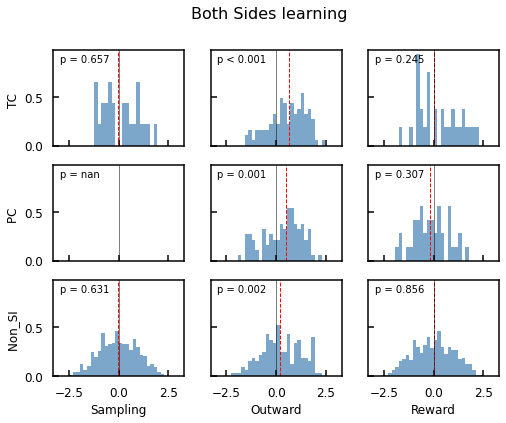

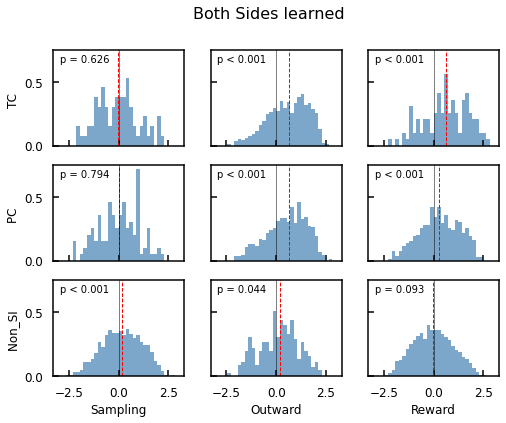

In [18]:
# Define sides (left and right) to create separate figures
sides = ['left', 'right']
contexts = ['sampling', 'outward', 'reward']
clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']

results_all = {}  # Store stats, p-values, and n for each test

# Create separate figures for left and right sides
for phase in ['learning', 'learned']:
    results_dict = {}  # Store results for the current phase
    fig, axes = plt.subplots(len(clusters), len(contexts), figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle("Both Sides " + phase, fontsize=16)

    for i, cluster in enumerate(clusters):
        for j, context in enumerate(contexts):
            # Extract Z values
            z_values_l = pf.extract_z_values_by_context_cluster_side(replay_stats, phase, context, cluster, 'left')
            z_values_r = pf.extract_z_values_by_context_cluster_side(replay_stats, phase, context, cluster, 'right')
            z_values = np.concatenate((z_values_l, z_values_r))
            z_values = z_values[~np.isnan(z_values)]  # Remove NaNs
            
            # Perform the statistical test if enough data
            if len(z_values) > 1:  # Ensure there are enough values to perform the test
                stat, p_value = wilcoxon(z_values)
            else:
                stat, p_value = np.nan, np.nan  # Not enough data
            
            # Save the results in the dictionary
            key = f"{context}_{cluster}"
            results_dict[key] = {
                'stat': stat,
                'p_value': p_value,
                'n': len(z_values)
            }

            # Compute and plot histogram
            counts, bin_edges = np.histogram(z_values, bins=np.linspace(-3, 3, 35))
            bin_width = bin_edges[1] - bin_edges[0]
            pdf_values = counts / (np.sum(counts) * bin_width)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            axes[i, j].bar(bin_centers, pdf_values, width=bin_width, alpha=0.7, color='steelblue')

            # Add p-value text to the plot
            if p_value < 0.001:
                p_text = "p < 0.001"
            else:
                p_text = f"p = {p_value:.3f}"
            axes[i, j].text(0.05, 0.95, p_text, transform=axes[i, j].transAxes, 
                            fontsize=10, verticalalignment='top')

            # Mark median line
            if len(z_values) > 0:
                median_value = np.median(z_values)
                axes[i, j].axvline(median_value, color='r', linestyle='--', linewidth=1)
            axes[i, j].axvline(0, color='k', linewidth=0.5)

            # Label axes
            axes[i, 0].set_ylabel(f"{cluster.replace('_cluster', ' ')}", fontsize=12)
            axes[2, j].set_xlabel(f"{context.capitalize()}", fontsize=12)

    results_all[phase] = results_dict  # Store results for the phase

# Display or save the results table
import pandas as pd
for phase, results in results_all.items():
    df = pd.DataFrame.from_dict(results, orient='index')
    print(f"\nResults for phase: {phase}")
    print(df)


In [19]:
results_all

{'learning': {'sampling_TC_cluster': {'stat': 158.0,
   'p_value': 0.656706715768133,
   'n': 26},
  'outward_TC_cluster': {'stat': 1060.0,
   'p_value': 6.112163543882676e-08,
   'n': 104},
  'reward_TC_cluster': {'stat': 176.0,
   'p_value': 0.24519030932096386,
   'n': 30},
  'sampling_PC_cluster': {'stat': nan, 'p_value': nan, 'n': 0},
  'outward_PC_cluster': {'stat': 1743.0,
   'p_value': 0.001371175368969114,
   'n': 104},
  'reward_PC_cluster': {'stat': 334.0, 'p_value': 0.3069993330132629, 'n': 40},
  'sampling_Non_SI_cluster': {'stat': 82589.0,
   'p_value': 0.6306144601413346,
   'n': 581},
  'outward_Non_SI_cluster': {'stat': 6127.0,
   'p_value': 0.0019985251895606572,
   'n': 182},
  'reward_Non_SI_cluster': {'stat': 232435.0,
   'p_value': 0.855771721870251,
   'n': 967}},
 'learned': {'sampling_TC_cluster': {'stat': 1297.0,
   'p_value': 0.6258722666123258,
   'n': 74},
  'outward_TC_cluster': {'stat': 60193.0,
   'p_value': 5.031885727672613e-42,
   'n': 750},
  'reward

In [17]:
pval_all

{'learning': {'sampling_TC_cluster': 0.375732421875,
  'outward_TC_cluster': 4.632469318082196e-06,
  'reward_TC_cluster': 0.10699462890625,
  'sampling_PC_cluster': nan,
  'outward_PC_cluster': 0.011350366755335335,
  'reward_PC_cluster': 0.7011814117431641,
  'sampling_Non_SI_cluster': 0.9562394467886204,
  'outward_Non_SI_cluster': 0.004787167737533924,
  'reward_Non_SI_cluster': 0.8447675529887254},
 'learned': {'sampling_TC_cluster': 0.4109616150946165,
  'outward_TC_cluster': 1.1134690128088895e-21,
  'reward_TC_cluster': 9.694681862782454e-06,
  'sampling_PC_cluster': 0.939890942433329,
  'outward_PC_cluster': 1.6350255330393032e-10,
  'reward_PC_cluster': 1.3766996665596092e-07,
  'sampling_Non_SI_cluster': 7.600252057047396e-06,
  'outward_Non_SI_cluster': 0.23161486059863445,
  'reward_Non_SI_cluster': 0.3444016782399155}}

In [66]:
boz

NameError: name 'boz' is not defined

: 

: 

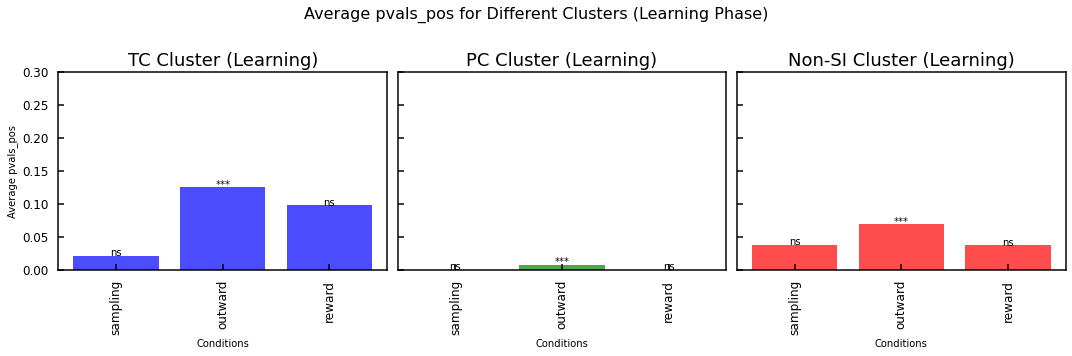

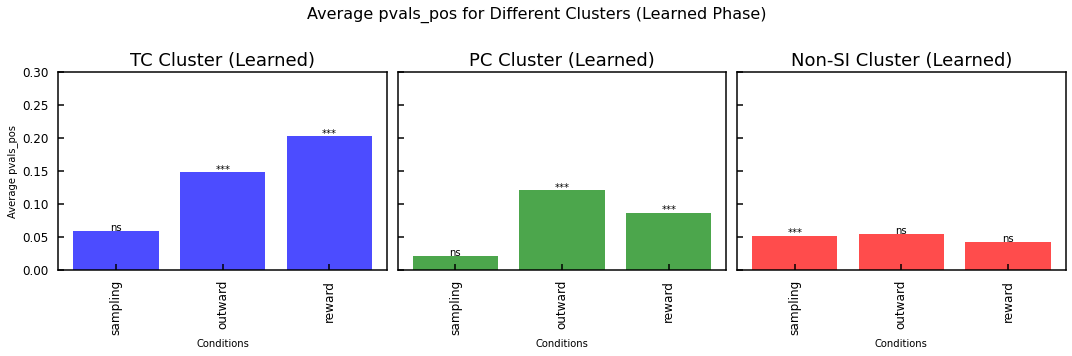

: 

: 

In [94]:
# Define function to process and plot data for both phases
def plot_phase_data(combined_results_df, pval_all, phase):
    # Extract data for the given phase
    data = combined_results_df[phase]
    p_values_dict = pval_all[phase]

    # Conditions
    conditions = ["sampling_L", "sampling_R", "outward_L", "outward_R", "reward_L", "reward_R"]

    # Create a DataFrame
    df = pd.DataFrame(data, index=conditions)
    df = df.filter(like='pos_ratio_one_sided')

    # Calculate the average of left and right for each condition (pairwise averaging)
    average_conditions = df.groupby(df.index.str.replace('_L|_R', '', regex=True)).mean()

    # Reorder the conditions to be "sampling", "outward", "reward"
    average_conditions = average_conditions.reindex(["sampling", "outward", "reward"])

    # Create subplots for each cluster type based on reordered averaged conditions using bar plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # Function to convert p-values to significance markers
    def get_significance_marker(p_value):
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        else:
            return 'ns'

    # Plot TC cluster
    axes[0].bar(average_conditions.index, average_conditions[["TC_left", "TC_right"]].mean(axis=1), color='b', alpha=0.7, label="TC Cluster")
    axes[0].set_title(f"TC Cluster ({phase.capitalize()})")
    axes[0].set_xlabel("Conditions")
    axes[0].set_ylabel("Average pvals_pos")
    axes[0].set_ylim([0,.3])
    axes[0].tick_params(axis='x', rotation=90)
    for i, condition in enumerate(average_conditions.index):
        significance = get_significance_marker(p_values_dict[condition + '_TC_cluster'])
        axes[0].text(i, average_conditions[["TC_left", "TC_right"]].mean(axis=1).iloc[i] , significance, ha='center')

    # Plot PC cluster
    axes[1].bar(average_conditions.index, average_conditions[["PC_left", "PC_right"]].mean(axis=1), color='g', alpha=0.7, label="PC Cluster")
    axes[1].set_title(f"PC Cluster ({phase.capitalize()})")
    axes[1].set_xlabel("Conditions")
    #axes[1].set_ylim([0,.3])
    axes[1].tick_params(axis='x', rotation=90)
    for i, condition in enumerate(average_conditions.index):
        significance = get_significance_marker(p_values_dict[condition + '_PC_cluster'])
        axes[1].text(i, average_conditions[["PC_left", "PC_right"]].mean(axis=1).iloc[i] , significance, ha='center')

    # Plot Non-SI cluster
    axes[2].bar(average_conditions.index, average_conditions[["Non_SI_left", "Non_SI_right"]].mean(axis=1), color='r', alpha=0.7, label="Non-SI Cluster")
    axes[2].set_title(f"Non-SI Cluster ({phase.capitalize()})")
    axes[2].set_xlabel("Conditions")
    axes[2].tick_params(axis='x', rotation=90)
    axes[2].set_ylim([0,.3])
    for i, condition in enumerate(average_conditions.index):
        significance = get_significance_marker(p_values_dict[condition + '_Non_SI_cluster'])
        axes[2].text(i, average_conditions[["Non_SI_left", "Non_SI_right"]].mean(axis=1).iloc[i], significance, ha='center')

    # Adjust layout
    plt.suptitle(f"Average pvals_pos for Different Clusters ({phase.capitalize()} Phase)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()

# Plot data for both learning and learned phases
for phase in ["learning", "learned"]:
    plot_phase_data(combined_burst_ratios_df, pval_all, phase)

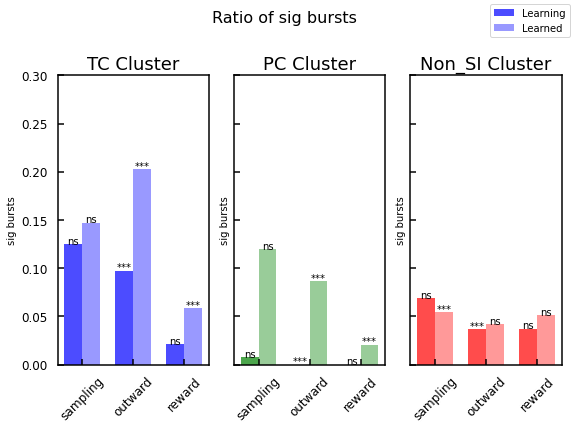

: 

: 

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define function to process and plot data for both phases

def plot_phase_data(combined_results_df, pval_all):
    phases = ["learning", "learned"]

    # Extract data for both phases
    data_learning = combined_results_df["learning"]
    data_learned = combined_results_df["learned"]

    data_learning = data_learning.filter(like='pos_ratio_one_sided')
    data_learned = data_learned.filter(like='pos_ratio_one_sided')

    p_values_learning = pval_all["learning"]
    p_values_learned = pval_all["learned"]

    # Conditions
    conditions = ["sampling", "outward", "reward"]

    # Create DataFrames for both phases
    df_learning = pd.DataFrame(data_learning).groupby(lambda x: x.replace('_L', '').replace('_R', '')).mean()
    df_learned = pd.DataFrame(data_learned).groupby(lambda x: x.replace('_L', '').replace('_R', '')).mean()

    # Create subplots for each cluster type based on reordered averaged conditions using bar plots
    fig, axes = plt.subplots(1, 3, figsize=(8, 6), sharey=True)

    # Function to convert p-values to significance markers
    def get_significance_marker(p_value):
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        else:
            return 'ns'

    cluster_types = ["TC", "PC", "Non_SI"]
    colors = ['b', 'g', 'r']

    for ax, cluster, color in zip(axes, cluster_types, colors):
        learning_means = df_learning.filter(like=cluster).mean(axis=1)
        learned_means = df_learned.filter(like=cluster).mean(axis=1)

        x = np.arange(len(conditions))
        width = 0.35

        # Plot bars for learning and learned phases
        ax.bar(x - width/2, learning_means, width, label='Learning', color=color, alpha=0.7)
        ax.bar(x + width/2, learned_means, width, label='Learned', color=color, alpha=0.4)

        # Add significance markers
        for i, condition in enumerate(conditions):
            learning_sig = get_significance_marker(p_values_learning[f"{condition}_{cluster}_cluster"])
            learned_sig = get_significance_marker(p_values_learned[f"{condition}_{cluster}_cluster"])
            ax.text(i - width/2, learning_means[i] , learning_sig, ha='center')
            ax.text(i + width/2, learned_means[i] , learned_sig, ha='center')

        ax.set_title(f"{cluster} Cluster")
        #ax.set_xlabel("Conditions")
        ax.set_xticks(x)
        ax.set_xticklabels(conditions)
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel("sig bursts")
        ax.set_ylim([0,.3])

    # Adjust layout and add legend
    plt.suptitle("Ratio of sig bursts", fontsize=16)
    fig.legend(labels=["Learning", "Learned"], loc="upper right")
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()

# Plot data
plot_phase_data(combined_burst_ratios_df, pval_all)


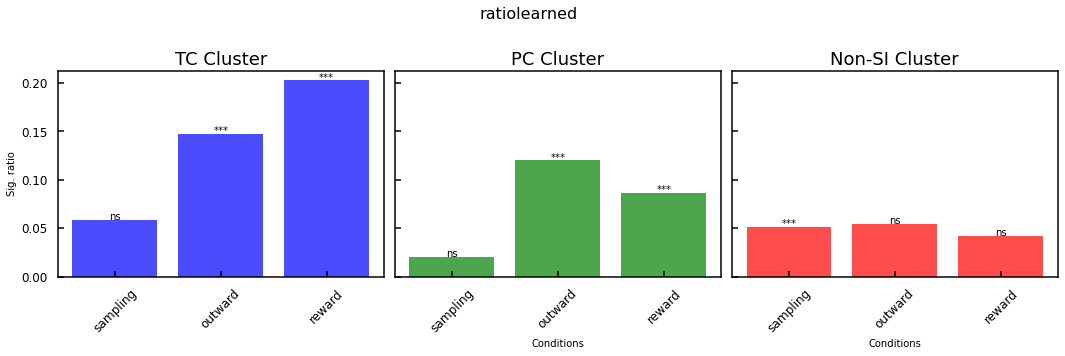

: 

: 

In [57]:
# Conditions
conditions = ["sampling_L", "sampling_R", "outward_L", "outward_R", "reward_L", "reward_R"]

# Create a DataFrame
df = pd.DataFrame(combined_results_df, index=conditions)

#pos_ratio_df = pd.DataFrame(combined_results_df, index=conditions)

df = df.filter(like='pos_ratio_one_sided')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate the average of left and right for each condition (pairwise averaging)
average_conditions = df.groupby(df.index.str.replace('_L|_R', '', regex=True)).mean()

# Reorder the conditions to be "sampling", "outward", "reward"
average_conditions = average_conditions.reindex(["sampling", "outward", "reward"])

# Create subplots for each cluster type based on reordered averaged conditions using bar plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Function to convert p-values to significance markers
def get_significance_marker(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

# Plot TC cluster
axes[0].bar(average_conditions.index, average_conditions[["TC_left", "TC_right"]].mean(axis=1), color='b', alpha=0.7, label="TC Cluster")
axes[0].set_title("TC Cluster")
#axes[0].set_xlabel("Conditions")
axes[0].set_ylabel("Sig. ratio")
axes[0].tick_params(axis='x', rotation=45)
for i, condition in enumerate(average_conditions.index):
    significance = get_significance_marker(p_values_dict[condition + '_TC_cluster'])
    axes[0].text(i, average_conditions[["TC_left", "TC_right"]].mean(axis=1).iloc[i] , significance, ha='center')

# Plot PC cluster
axes[1].bar(average_conditions.index, average_conditions[["PC_left", "PC_right"]].mean(axis=1), color='g', alpha=0.7, label="PC Cluster")
axes[1].set_title("PC Cluster")
axes[1].set_xlabel("Conditions")
axes[1].tick_params(axis='x', rotation=45)
for i, condition in enumerate(average_conditions.index):
    significance = get_significance_marker(p_values_dict[condition + '_PC_cluster'])
    axes[1].text(i, average_conditions[["PC_left", "PC_right"]].mean(axis=1).iloc[i] , significance, ha='center')

# Plot Non-SI cluster
axes[2].bar(average_conditions.index, average_conditions[["Non_sig_left", "Non_sig_right"]].mean(axis=1), color='r', alpha=0.7, label="Non-SI Cluster")
axes[2].set_title("Non-SI Cluster")
axes[2].set_xlabel("Conditions")
axes[2].tick_params(axis='x', rotation=45)
for i, condition in enumerate(average_conditions.index):
    significance = get_significance_marker(p_values_dict[condition + '_Non_SI_cluster'])
    axes[2].text(i, average_conditions[["Non_sig_left", "Non_sig_right"]].mean(axis=1).iloc[i] , significance, ha='center')

# Adjust layout
plt.suptitle("ratio"+phase, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


# # Create subplots for each cluster type based on reordered averaged conditions using bar plots
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# # Plot TC cluster
# axes[0].bar(average_conditions.index, average_conditions[["TC_left", "TC_right"]].mean(axis=1), color='b', alpha=0.7, label="TC Cluster")
# axes[0].set_title("TC Cluster")
# axes[0].set_xlabel("Conditions")
# axes[0].set_ylabel("Average pvals_pos")
# axes[0].tick_params(axis='x', rotation=45)
# for i, condition in enumerate(average_conditions.index):
#     axes[0].text(i, average_conditions[["TC_left", "TC_right"]].mean(axis=1).iloc[i] + 0.5, f"p={p_values_dict[condition + '_TC_cluster']:.2g}", ha='center')

# # Plot PC cluster
# axes[1].bar(average_conditions.index, average_conditions[["PC_left", "PC_right"]].mean(axis=1), color='g', alpha=0.7, label="PC Cluster")
# axes[1].set_title("PC Cluster")
# axes[1].set_xlabel("Conditions")
# axes[1].tick_params(axis='x', rotation=45)
# for i, condition in enumerate(average_conditions.index):
#     axes[1].text(i, average_conditions[["PC_left", "PC_right"]].mean(axis=1).iloc[i] + 0.5, f"p={p_values_dict[condition + '_PC_cluster']:.2g}", ha='center')

# # Plot Non-SI cluster
# axes[2].bar(average_conditions.index, average_conditions[["Non_sig_left", "Non_sig_right"]].mean(axis=1), color='r', alpha=0.7, label="Non-SI Cluster")
# axes[2].set_title("Non-SI Cluster")
# axes[2].set_xlabel("Conditions")
# axes[2].tick_params(axis='x', rotation=45)
# for i, condition in enumerate(average_conditions.index):
#     axes[2].text(i, average_conditions[["Non_sig_left", "Non_sig_right"]].mean(axis=1).iloc[i] + 0.5, f"p={p_values_dict[condition + '_Non_SI_cluster']:.2g}", ha='center')

# # Adjust layout
# plt.suptitle("Average pvals_pos for Different Clusters (Left and Right Combined)", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Show the plot
# plt.show()

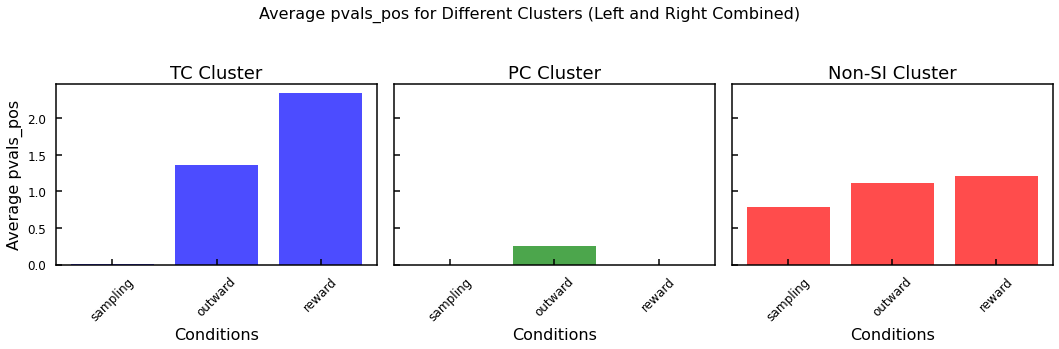

: 

: 

In [392]:




# Conditions
conditions = ["sampling_L", "sampling_R", "outward_L", "outward_R", "reward_L", "reward_R"]

# Create a DataFrame
df = pd.DataFrame(combined_results_df, index=conditions)

# Calculate the average of left and right for each condition (pairwise averaging)
average_conditions = df.groupby(df.index.str.replace('_L|_R', '', regex=True)).mean()

# Reorder the conditions to be "sampling", "outward", "reward"
average_conditions = average_conditions.reindex(["sampling", "outward", "reward"])

# Create subplots for each cluster type based on reordered averaged conditions using bar plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot TC cluster
axes[0].bar(average_conditions.index, average_conditions[["TC_left", "TC_right"]].mean(axis=1), color='b', alpha=0.7, label="TC Cluster")
axes[0].set_title("TC Cluster")
axes[0].set_xlabel("Conditions")
axes[0].set_ylabel("Average pvals_pos")
axes[0].tick_params(axis='x', rotation=45)

# Plot PC cluster
axes[1].bar(average_conditions.index, average_conditions[["PC_left", "PC_right"]].mean(axis=1), color='g', alpha=0.7, label="PC Cluster")
axes[1].set_title("PC Cluster")
axes[1].set_xlabel("Conditions")
axes[1].tick_params(axis='x', rotation=45)

# Plot Non-SI cluster
axes[2].bar(average_conditions.index, average_conditions[["Non_sig_left", "Non_sig_right"]].mean(axis=1), color='r', alpha=0.7, label="Non-SI Cluster")
axes[2].set_title("Non-SI Cluster")
axes[2].set_xlabel("Conditions")
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.suptitle("Average pvals_pos for Different Clusters (Left and Right Combined)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

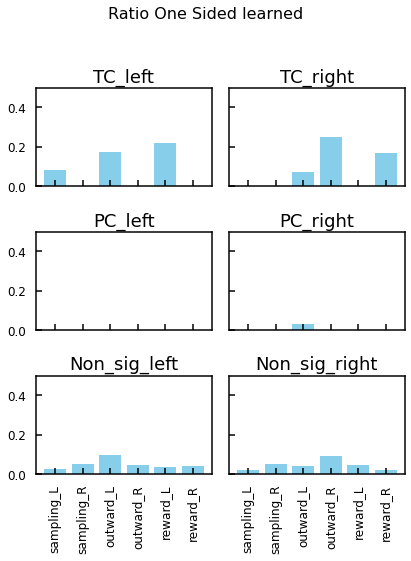

: 

: 

In [385]:
# Extracting only the 'pos_ratio_one_sided' columns
# Convert to DataFrame
# Condition names
conditions = ["sampling_L", "sampling_R", "outward_L", "outward_R", "reward_L", "reward_R"]
# Creating a DataFrame with only 'pos_ratio_one_sided' values from the data_correct dictionary
pos_ratio_df = pd.DataFrame(combined_results_df, index=conditions)

pos_ratio_one_sided_df = pos_ratio_df.filter(like='pos_ratio_one_sided')

# Creating subplots for each cluster type
fig, axes = plt.subplots(3, 2, figsize=(6, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting each cluster type
for ax, (cluster, values) in zip(axes, pos_ratio_one_sided_df.items()):
    ax.bar(pos_ratio_one_sided_df.index, values, color="skyblue")
    ax.set_title(cluster[0])
    ax.set_ylim([0,.5])
    ax.tick_params(axis="x", rotation=90)

# Adjust layout and add title
fig.suptitle("Ratio One Sided "+ phase, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


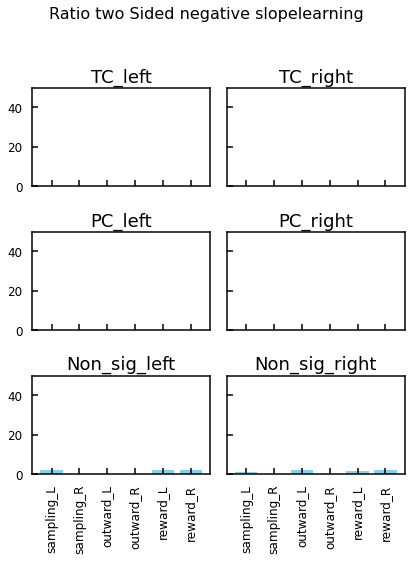

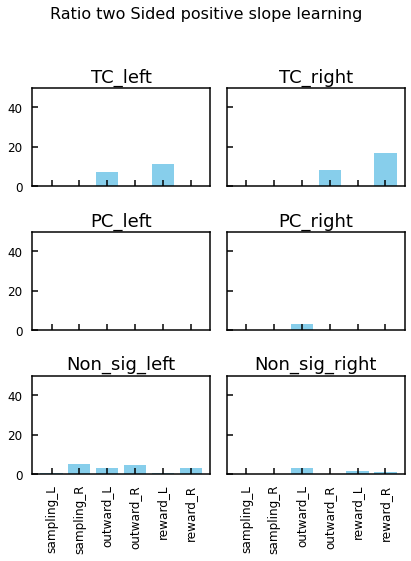

: 

: 

In [325]:
# Extracting only the 'pos_ratio_one_sided' columns
pos_ratio_one_sided_df = pos_ratio_df.filter(like='pvals_neg')

# Creating subplots for each cluster type
fig, axes = plt.subplots(3, 2, figsize=(6, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting each cluster type
for ax, (cluster, values) in zip(axes, pos_ratio_one_sided_df.items()):
    ax.bar(pos_ratio_one_sided_df.index, values, color="skyblue")
    ax.set_title(cluster[0])
    ax.set_ylim([0,50])
    ax.tick_params(axis="x", rotation=90)

# Adjust layout and add title
fig.suptitle("Ratio two Sided negative slope"+ phase, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()



# Extracting only the 'pos_ratio_one_sided' columns
pos_ratio_one_sided_df = pos_ratio_df.filter(like='pvals_pos')

# Creating subplots for each cluster type
fig, axes = plt.subplots(3, 2, figsize=(6, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting each cluster type
for ax, (cluster, values) in zip(axes, pos_ratio_one_sided_df.items()):
    ax.bar(pos_ratio_one_sided_df.index, values, color="skyblue")
    ax.set_title(cluster[0])
    ax.set_ylim([0,50])
    ax.tick_params(axis="x", rotation=90)

# Adjust layout and add title
fig.suptitle("Ratio two Sided positive slope "+ phase, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

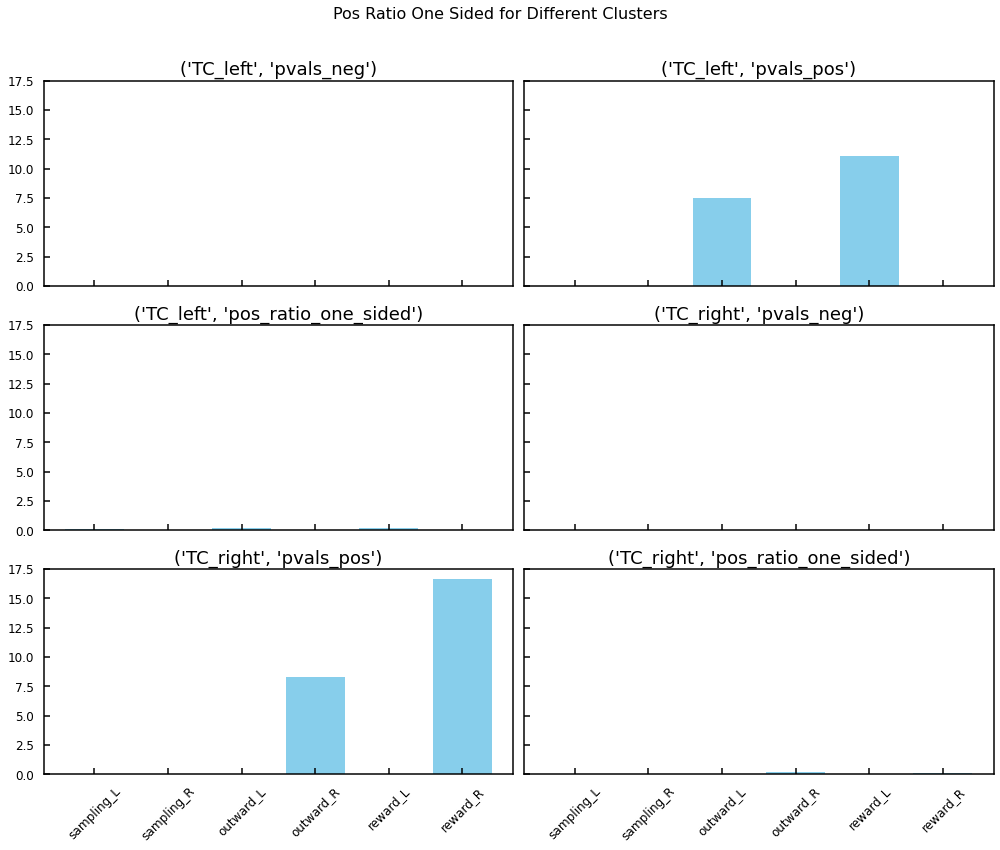

: 

: 

In [263]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Defining the data
data_correct = dict(df_correct)

# Defining the conditions
conditions = ["sampling_L", "sampling_R", "outward_L", "outward_R", "reward_L", "reward_R"]

# Creating a DataFrame
df = pd.DataFrame(data_correct, index=conditions)

# Creating subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting each cluster type
for ax, cluster in zip(axes, df.columns):
    ax.bar(df.index, df[cluster], color="skyblue")
    ax.set_title(cluster)
    ax.tick_params(axis="x", rotation=45)

# Adjust layout and add title
fig.suptitle("Pos Ratio One Sided for Different Clusters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\743727020.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(contexts, rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\743727020.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(contexts, rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\743727020.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(contexts, rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\743727020.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(contexts, rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468

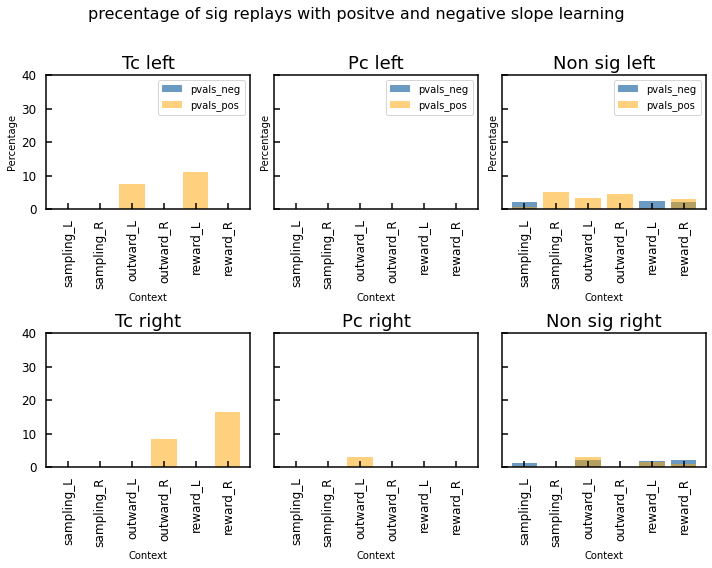

: 

: 

In [231]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert to DataFrame

# List of contexts (index labels)
contexts = ['sampling_L', 'sampling_R', 'outward_L', 'outward_R', 'reward_L', 'reward_R']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8), sharey=True)
fig.suptitle('precentage of sig replays with positve and negative slope '+ phase, fontsize=16)

# Define the order of plots: left on top row, right on bottom row
columns_order = [
    'TC_left', 'PC_left', 'Non_sig_left',
    'TC_right', 'PC_right', 'Non_sig_right'
]

# Iterate over each cluster-side combination and plot in the correct position
for ax, column in zip(axes.flatten(), columns_order):
    
    ax.bar(contexts, combined_results_df[column]['pvals_neg'], alpha=0.8, label='pvals_neg', color='steelblue')
    ax.bar(contexts, combined_results_df[column]['pvals_pos'], alpha=0.5, label='pvals_pos', color='orange')
    ax.set_title(column.replace('_', ' ').capitalize())
    ax.set_xlabel('Context')
    ax.set_xticklabels(contexts, rotation=90)
    ax.set_ylim([0,40])
    if 'left' in column:
        ax.set_ylabel('Percentage')
        ax.legend()
    if i == 0:
        ax.set_ylabel('Percentage')
        ax.legend()
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [211]:
# Updated function to extract Z values for both _L and _R keys
def extract_z_values_by_context_pair(replay_stats, condition, context, cluster_name, side):
    z_values_L = []
    z_values_R = []

    if condition in replay_stats:
        for animal_id in replay_stats[condition].keys():
            cluster_data = replay_stats[condition][animal_id].get(cluster_name, {})
            if side in cluster_data:
                for key, condition_data in cluster_data[side].items():
                    # Check for _L keys
                    
                    if("_L" in key) & (context in key):
                        if 'Z' in condition_data:
                            z_values_L.extend(condition_data['Z'])
                    # Check for _R keys
                    if ("_R" in key) & (context in key):
                        if 'Z' in condition_data:
                            z_values_R.extend(condition_data['Z'])

    return np.array(z_values_L), np.array(z_values_R)

: 

: 

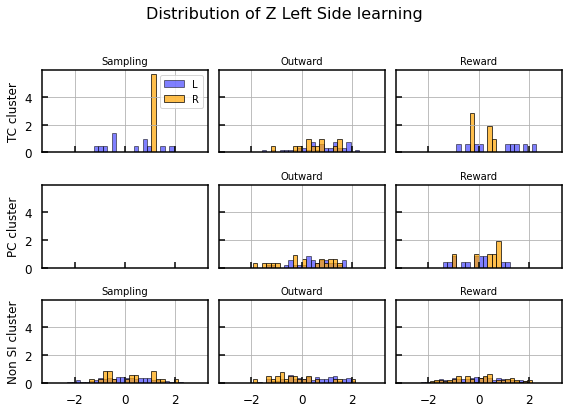

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

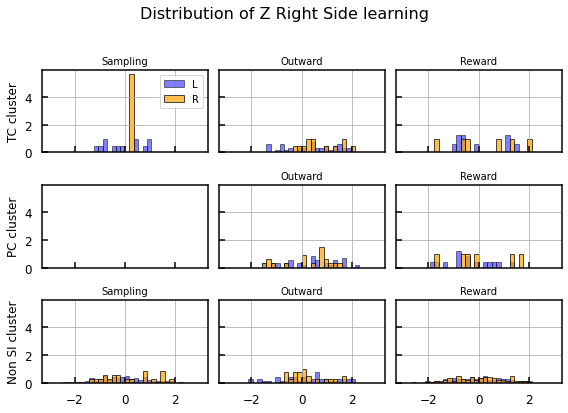

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

: 

: 

In [212]:


# Define contexts and clusters
contexts = ['sampling', 'outward', 'reward']
clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']
sides = ['left', 'right']

# Create separate figures for _L and _R
for side in sides:
    fig_L, axes_L = plt.subplots(len(clusters), len(contexts), figsize=(8, 6), sharex=True, sharey=True)
    fig_L.suptitle('Distribution of Z '+f"{side.capitalize()} Side "+ phase, fontsize=16)

    for context in contexts:
        # Plot _L values

        # Plot _R values
        # fig_R, axes_R = plt.subplots(len(clusters), len(contexts), figsize=(6, 4), sharex=True, sharey=True)
        # fig_R.suptitle(f"{context.capitalize()}_R - {side.capitalize()} Side", fontsize=16)

        for i, cluster in enumerate(clusters):
            for j, context in enumerate(contexts):
                # Extract Z values for _L and _R
                z_values_L, z_values_R = extract_z_values_by_context_pair(replay_stats, phase, context, cluster, side)

                # Compute and plot PDF for _L
                if z_values_L.size > 0:
                    counts_L, bin_edges = np.histogram(z_values_L, bins=np.linspace(-3, 3, 35))
                    bin_width = bin_edges[1] - bin_edges[0]
                    pdf_values_L = counts_L / (np.sum(counts_L) * bin_width)
                    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                    axes_L[i, j].bar(bin_centers, pdf_values_L, width=bin_width, alpha=0.5, edgecolor='black', color='blue',label='L')
                    axes_L[i, j].set_title(f"{context.capitalize()}", fontsize=10)
                    axes_L[i, j].grid(True)

                # Compute and plot PDF for _R
                if z_values_R.size > 0:
                    counts_R, bin_edges = np.histogram(z_values_R, bins=np.linspace(-3, 3, 35))
                    pdf_values_R = counts_R / (np.sum(counts_R) * bin_width)
                    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                    axes_L[i, j].bar(bin_centers, pdf_values_R, width=bin_width, alpha=0.7, edgecolor='black', color='orange',label='R')
                    axes_L[i, j].set_title(f"{context.capitalize()}", fontsize=10)
                    axes_L[i, 0].set_ylabel(f"{cluster.replace('_', ' ')}", fontsize=12)

                    axes_L[i, j].grid(True)
                if (i==0) & (j==0):
                    axes_L[i, j].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


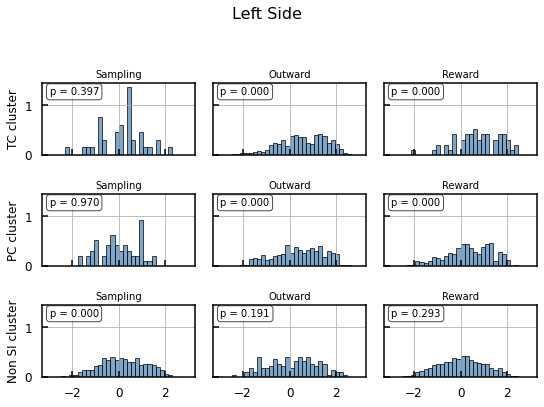

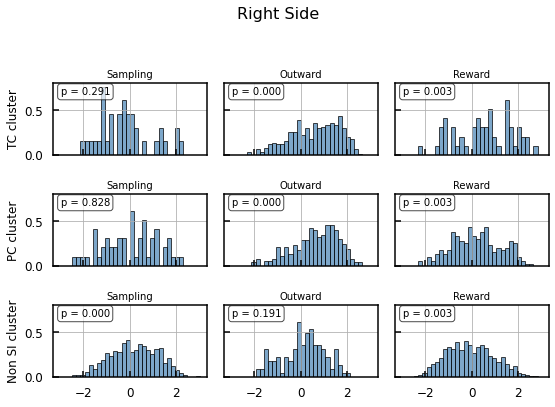

: 

: 

In [346]:
# Updated function to extract Z values for a specific context, cluster, and side (left/right)
def extract_z_values_by_context_cluster_side(replay_stats,condition, context, cluster_name, side):
    z_values = []
    if condition in replay_stats:
        for animal_id in replay_stats[condition].keys():
            cluster_data = replay_stats[condition][animal_id].get(cluster_name, {})
            if side in cluster_data:
                for key, condition_data in cluster_data[side].items():
                    if context in key.lower():
                        if 'Z' in condition_data:
                            z_values.extend(condition_data['Z'])
    return z_values

# Define sides (left and right) to create separate figures
sides = ['left', 'right']
contexts = ['sampling', 'outward', 'reward']
clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']
p_values_dict={}

# Create separate figures for left and right sides
for side in sides:
    fig, axes = plt.subplots(len(clusters), len(contexts), figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle(f"{side.capitalize()} Side", fontsize=16)
    
    for i, cluster in enumerate(clusters):
        for j, context in enumerate(contexts):
            # Extract Z values
            z_values = extract_z_values_by_context_cluster_side(replay_stats,phase, context, cluster, side)


            # Perform a one-sample t-test
            if len(z_values) > 1:  # Ensure there are enough values to perform the test
                t_stat, p_value = stats.ttest_1samp(z_values, 0)
            else:
                p_value = np.nan  # Not enough data

            # Save the p-value in the dictionary
            key = f"{context}_{cluster}_{side}"
            p_values_dict[key] = p_value

            # Step 1: Compute histogram
            # Step 1: Compute histogram
            counts, bin_edges = np.histogram(z_values, bins=np.linspace(-3, 3, 35))
            t_stat, p_value_ttest = stats.ttest_1samp(z_values, 0)
            # Step 2: Compute bin width
            bin_width = bin_edges[1] - bin_edges[0]

            # Step 3: Normalize the counts to compute the PDF
            pdf_values = counts / (np.sum(counts) * bin_width)

            # Step 4: Compute bin centers for plotting
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Step 5: Plot the PDF as a histogram of bars
            axes[i, j].bar(bin_centers, pdf_values, width=bin_width, alpha=0.7, edgecolor='black', color='steelblue')

            # Add p-value text to the plot
            axes[i, j].text(0.05, 0.95, f"p = {p_value:.3f}", transform=axes[i, j].transAxes, 
                           fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))
            
            # Plot the histogram
            #axes[i, j].hist(z_values, bins=np.linspace(-3,3,35),density=True, alpha=0.7, edgecolor='black', color='steelblue')
            axes[i, j].set_title(f"{context.capitalize()}", fontsize=10)
            axes[i, 0].set_ylabel(f"{cluster.replace('_', ' ')}", fontsize=12)
            axes[i, j].grid(True)

           # axes[i, j].set_ylim([0,500])
    # Add common labels
    #fig.text(0.5, 0.04, 'Context', ha='center', fontsize=14)
    #fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [349]:
counts, bin_edges = np.histogram(z_values, bins=np.linspace(-3, 3, 35))

: 

: 

In [200]:
# Verify the sum of the PDF to ensure it integrates to 1
def make_pdf(z_values, bins=35, range=(-3, 3)):
    # Compute histogram
    counts, bin_edges = np.histogram(z_values, bins=np.linspace(*range, bins))
    
    # Compute bin width
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Normalize to PDF
    pdf_values = counts / (np.sum(counts) * bin_width)
    return pdf_values,bin_edges

: 

: 

In [202]:
# Verify the sum of the PDF to ensure it integrates to 1
def check_pdf_sum(z_values, bins=35, range=(-3, 3)):
    # Compute histogram
    counts, bin_edges = np.histogram(z_values, bins=np.linspace(*range, bins))
    
    # Compute bin width
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Normalize to PDF
    pdf_values = counts / (np.sum(counts) * bin_width)
    
    # Check the sum of the PDF
    total_sum = np.sum(pdf_values * bin_width)
    return total_sum

# Sample Z values for testing
z_values_L_sample = np.random.normal(0, 1, 1000)  # Simulating some data
z_values_R_sample = np.random.normal(0, 1, 1000)

# Check the sum of the PDFs
pdf_sum_L = check_pdf_sum(z_values)
pdf_sum_R = check_pdf_sum(z_values_L)

pdf_sum_L, pdf_sum_R


(1.0, 1.0000000000000002)

: 

: 

In [203]:
replay_stats['learning']['478']['TC_cluster']['left'].keys()

dict_keys(['sampling_L', 'sampling_R', 'outward_L', 'outward_R', 'reward_L', 'reward_R', 'inward_L', 'inward_R'])

: 

: 

In [204]:
import pandas as pd

: 

: 

C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabel

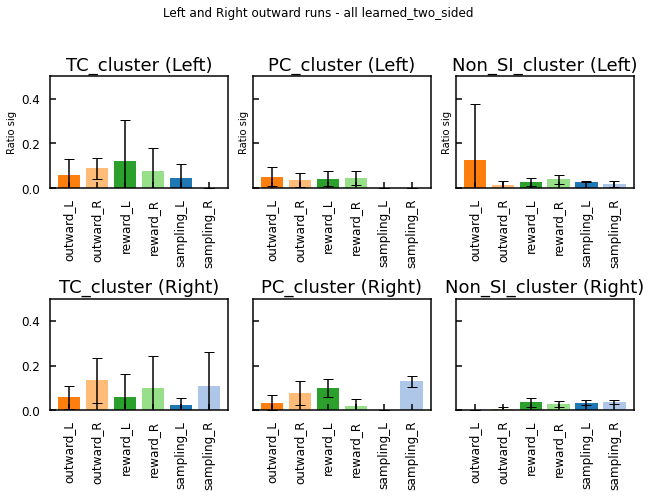

C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabel

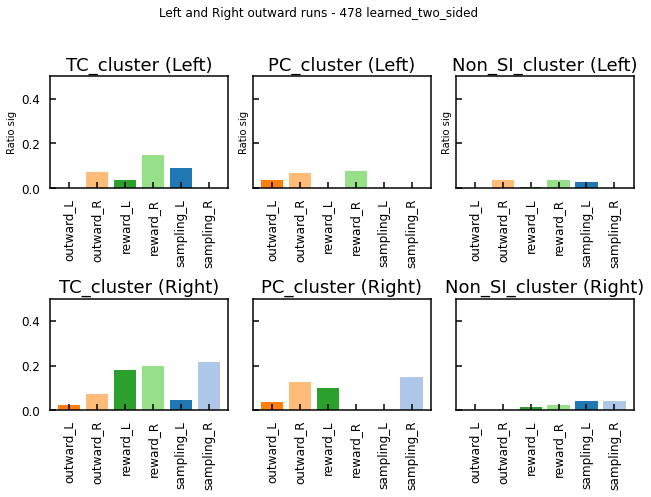

C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabel

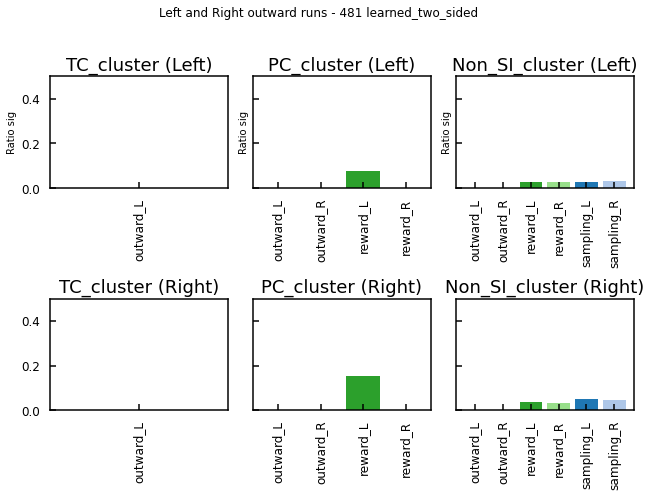

C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabel

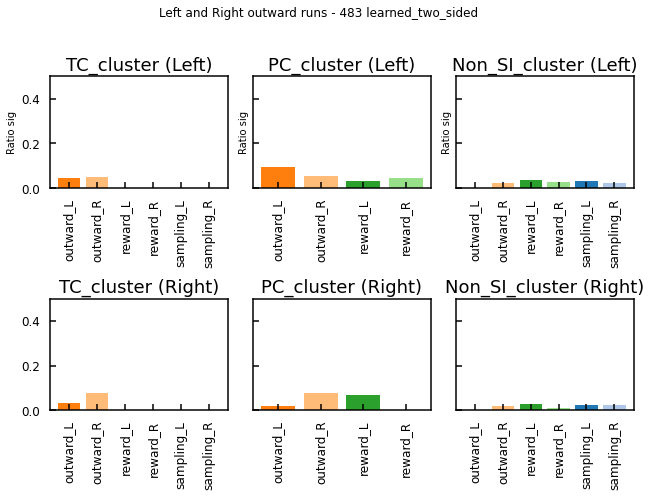

C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_1468\3035186894.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabel

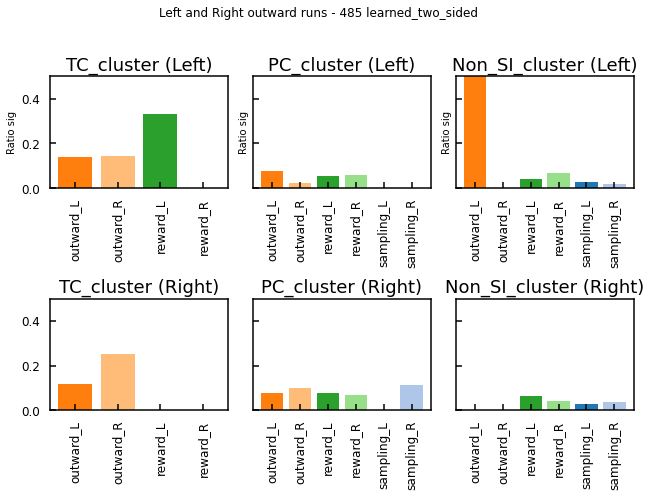

: 

: 

In [206]:
# Function to process animal data into a DataFrame
def process_animal_data(data):
    all_data = []
    if isinstance(data, dict):
        for animal, values in data.items():
            all_data.extend(values)
        animal_name = 'all'
    elif isinstance(data, list):
        all_data.extend(data)
        animal_name = 'single'
    return pd.DataFrame(all_data, columns=['Cluster', 'Direction', 'Metric', 'Value']), animal_name

# Function to plot bar charts with error bars
def plot_data(df, animal_name, significant_pairs=None):
    agg_data = df.groupby(['Cluster', 'Direction', 'Metric']).agg(['mean', 'std']).reset_index()
    agg_data.columns = ['Cluster', 'Direction', 'Metric', 'Mean', 'Std']

    colors = {
        'sampling_L': '#1f77b4',  # Dark blue
        'sampling_R': '#aec7e8',  # Light blue
        'outward_L': '#ff7f0e',   # Dark orange
        'outward_R': '#ffbb78',   # Light orange
        'reward_L': '#2ca02c',    # Dark green
        'reward_R': '#98df8a',    # Light green
    }

    fig, axes = plt.subplots(2, 3, figsize=(9, 7), sharey=True)

    for ax, cluster in zip(axes[0], ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']):
        cluster_data = agg_data[(agg_data['Cluster'] == cluster) & (agg_data['Direction'] == 'left')]
        for metric in cluster_data['Metric'].unique():
            metric_data = cluster_data[cluster_data['Metric'] == metric]
            ax.bar(
                metric,
                metric_data['Mean'].values[0],
                yerr=metric_data['Std'].values[0],
                color=colors.get(metric, '#333333'),
                capsize=5
            )
        ax.set_title(f'{cluster} (Left)')
        ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
        ax.set_ylabel('Ratio sig')
        ax.set_ylim([0,5])

    for ax, cluster in zip(axes[1], ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']):
        cluster_data = agg_data[(agg_data['Cluster'] == cluster) & (agg_data['Direction'] == 'right')]
        for metric in cluster_data['Metric'].unique():
            metric_data = cluster_data[cluster_data['Metric'] == metric]
            ax.bar(
                metric,
                metric_data['Mean'].values[0],
                yerr=metric_data['Std'].values[0],
                color=colors.get(metric, '#333333'),
                capsize=5
            )
        ax.set_title(f'{cluster} (Right)')
        ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
        ax.set_ylim([0,0.5])

    # Add significance stars if provided
    if significant_pairs:
        for pair in significant_pairs:
            ax = axes[0][0]  # Example: add stars to the first subplot
            x1, x2 = pair
            y, h, col = agg_data['Mean'].max() + 0.05, 0.02, 'k'
            ax.plot([x1, x2], [y, y], lw=1.5, c=col)
            ax.text((x1 + x2) * .5, y + h, '*', ha='center', va='bottom', color=col)


    fig.suptitle(f'Left and Right outward runs - {animal_name} ' )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
# Process and plot aggregated data

animal_sig_burst_ratio = animal_sig_burst_ratio_phase[phase]
df_all, animal_name = process_animal_data(animal_sig_burst_ratio)
plot_data(df_all, animal_name+' '+phase+'_two_sided')

# Process and plot data for a single animal
for anm in animal_sig_burst_ratio.keys():
    animal_sig_burst_ratio_anm = animal_sig_burst_ratio[anm]
    df_single, animal_name = process_animal_data(animal_sig_burst_ratio_anm)
    plot_data(df_single, anm+' '+phase+'_two_sided')

Kruskal-Wallis Test Results:
H-statistic: 0.2421
p-value: 6.2271e-01


C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3616228981.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3616228981.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3616228981.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3616228981.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickl

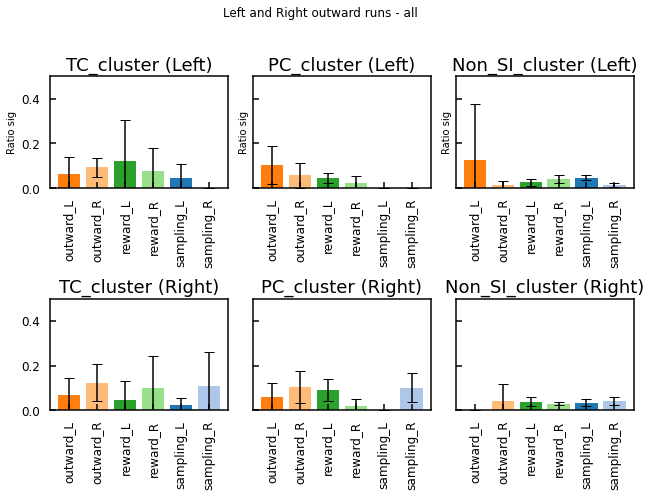

C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3616228981.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3616228981.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3616228981.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=90)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3616228981.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickl

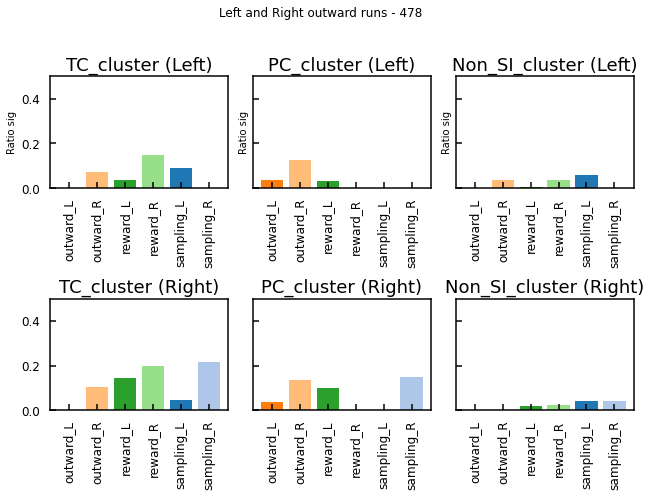

: 

: 

In [90]:
# Function to perform Kruskal-Wallis test between clusters and return significant pairs
from scipy.stats import kruskal
from itertools import combinations
def perform_kruskal(df):
    df = df.dropna(subset=['Value'])
    clusters = ['TC_cluster', 'PC_cluster', 'SI_cluster']
    values = [df[df['Cluster'] == cluster]['Value'].dropna().values for cluster in clusters]

    # Check if any group is empty
    non_empty_values = [v for v in values if len(v) > 0]
    if len(non_empty_values) < 2:
        print("Kruskal-Wallis Test cannot be performed: Not enough non-empty groups.")
        return

    h_stat, p_value = kruskal(*non_empty_values)
    print("Kruskal-Wallis Test Results:")
    print(f"H-statistic: {h_stat:.4f}")
    print(f"p-value: {p_value:.4e}")

    # Pairwise comparisons
    significant_pairs = []
    for (i, cluster1), (j, cluster2) in combinations(enumerate(clusters), 2):
        cluster1_values = df[df['Cluster'] == cluster1]['Value'].dropna()
        cluster2_values = df[df['Cluster'] == cluster2]['Value'].dropna()
        stat, p = kruskal(cluster1_values, cluster2_values)
        if p < 0.05:
            significant_pairs.append((i, j))

    return significant_pairs

# Example usage
# Process and plot aggregated data
df_all, animal_name = process_animal_data(animal_sig_burst_ratio)
significant_pairs = perform_kruskal(df_all)
plot_data(df_all, animal_name, significant_pairs)

# Process and plot data for a single animal
animal_sig_burst_ratio_anm = animal_sig_burst_ratio['478']
df_single, animal_name = process_animal_data(animal_sig_burst_ratio_anm)
plot_data(df_single, '478')


Kruskal-Wallis Test Results:
H-statistic: 3.2903
p-value: 1.9298e-01
Comparing TC_cluster vs PC_cluster: p-value = 6.2271e-01
Comparing TC_cluster vs Non_SI_cluster: p-value = 1.2673e-01
Comparing PC_cluster vs Non_SI_cluster: p-value = 1.4244e-01


C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickl

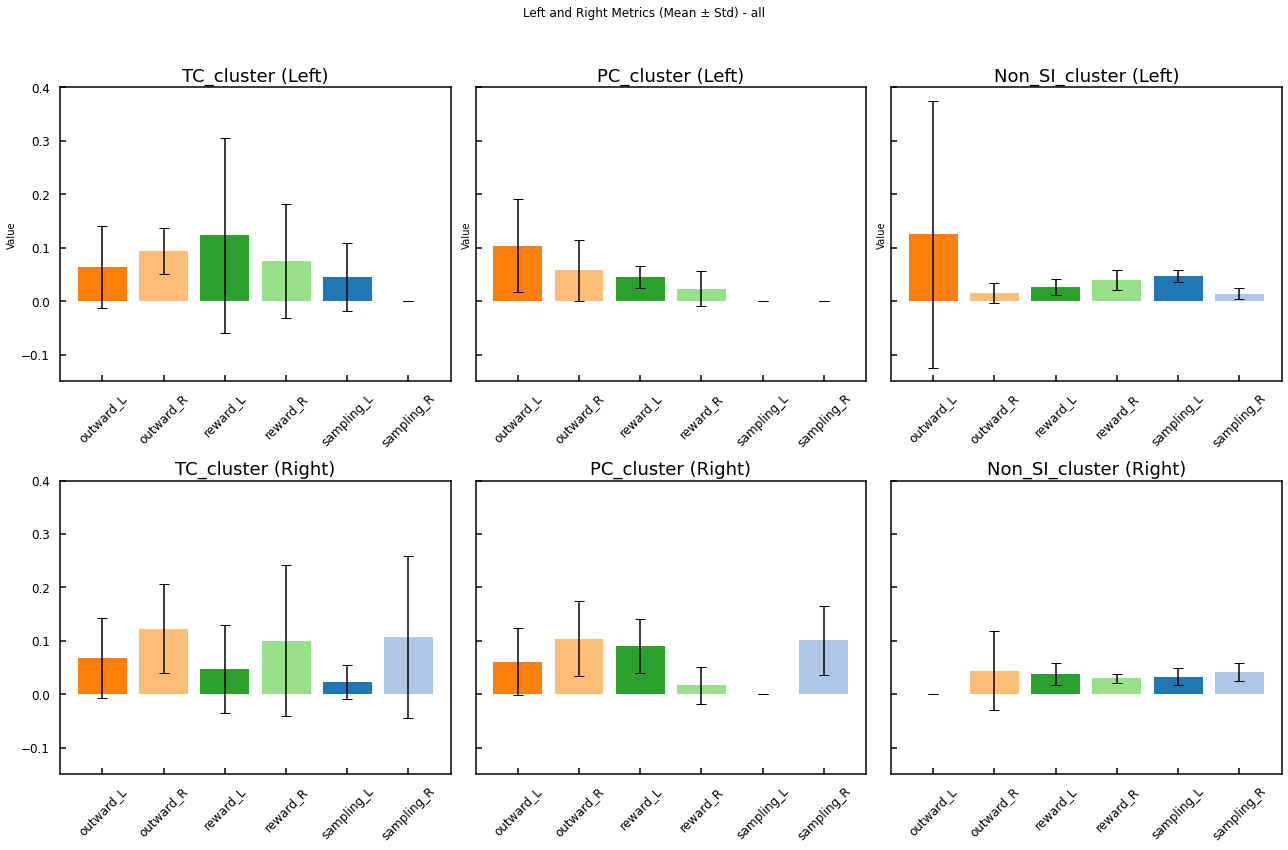

C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickl

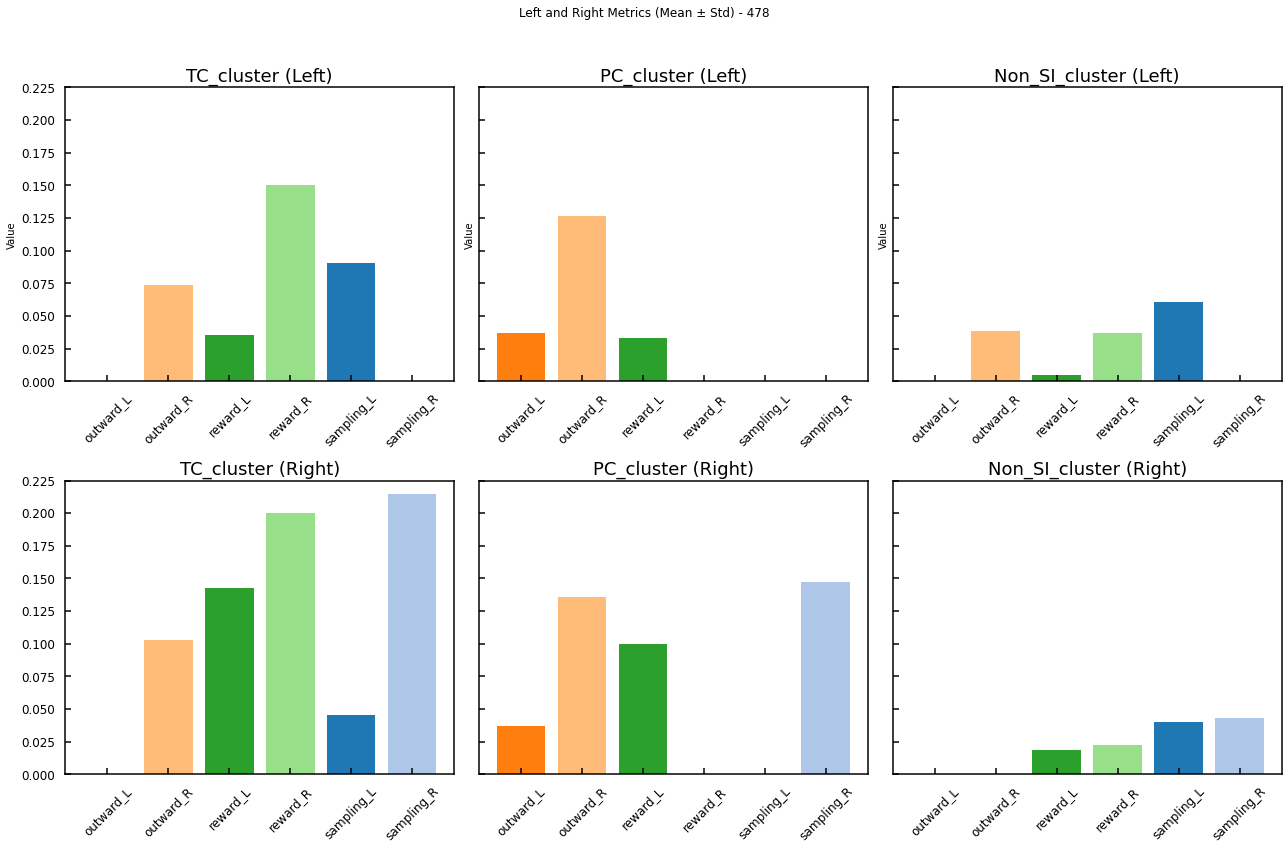

: 

: 

In [101]:

# Function to process animal data into a DataFrame
def process_animal_data(data):
    all_data = []
    if isinstance(data, dict):
        for animal, values in data.items():
            all_data.extend(values)
        animal_name = 'all'
    elif isinstance(data, list):
        all_data.extend(data)
        animal_name = 'single'
    return pd.DataFrame(all_data, columns=['Cluster', 'Direction', 'Metric', 'Value']), animal_name

# Function to plot bar charts with error bars
def plot_data(df, animal_name, significant_pairs=None):
    agg_data = df.groupby(['Cluster', 'Direction', 'Metric']).agg(['mean', 'std']).reset_index()
    agg_data.columns = ['Cluster', 'Direction', 'Metric', 'Mean', 'Std']

    colors = {
        'sampling_L': '#1f77b4',  # Dark blue
        'sampling_R': '#aec7e8',  # Light blue
        'outward_L': '#ff7f0e',   # Dark orange
        'outward_R': '#ffbb78',   # Light orange
        'reward_L': '#2ca02c',    # Dark green
        'reward_R': '#98df8a',    # Light green
    }

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

    for ax, cluster in zip(axes[0], ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']):
        cluster_data = agg_data[(agg_data['Cluster'] == cluster) & (agg_data['Direction'] == 'left')]
        for metric in cluster_data['Metric'].unique():
            metric_data = cluster_data[cluster_data['Metric'] == metric]
            ax.bar(
                metric,
                metric_data['Mean'].values[0],
                yerr=metric_data['Std'].values[0],
                color=colors.get(metric, '#333333'),
                capsize=5
            )
        ax.set_title(f'{cluster} (Left)')
        ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
        ax.set_ylabel('Value')

    for ax, cluster in zip(axes[1], ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']):
        cluster_data = agg_data[(agg_data['Cluster'] == cluster) & (agg_data['Direction'] == 'right')]
        for metric in cluster_data['Metric'].unique():
            metric_data = cluster_data[cluster_data['Metric'] == metric]
            ax.bar(
                metric,
                metric_data['Mean'].values[0],
                yerr=metric_data['Std'].values[0],
                color=colors.get(metric, '#333333'),
                capsize=5
            )
        ax.set_title(f'{cluster} (Right)')
        ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)

    # Add significance stars if provided
    if significant_pairs:
        for pair in significant_pairs:
            cluster1, cluster2 = pair
            ax = axes[0][0]  # Example: add stars to the first subplot
            y, h, col = agg_data['Mean'].max() + 0.05, 0.02, 'k'
            ax.plot([cluster1, cluster2], [y, y], lw=1.5, c=col)
            ax.text((cluster1 + cluster2) * .5, y + h, '*', ha='center', va='bottom', color=col)

    fig.suptitle(f'Left and Right Metrics (Mean ± Std) - {animal_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Function to perform Kruskal-Wallis test between clusters and return significant pairs
def perform_kruskal(df):
    df = df.dropna(subset=['Value'])
    clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']
    values = {cluster: df[df['Cluster'] == cluster]['Value'].dropna().values for cluster in clusters}

    # Check if any group is empty
    non_empty_values = {k: v for k, v in values.items() if len(v) > 0}
    if len(non_empty_values) < 2:
        print("Kruskal-Wallis Test cannot be performed: Not enough non-empty groups.")
        return []

    h_stat, p_value = kruskal(*non_empty_values.values())
    print("Kruskal-Wallis Test Results:")
    print(f"H-statistic: {h_stat:.4f}")
    print(f"p-value: {p_value:.4e}")

    # Pairwise comparisons with verbose output
    significant_pairs = []
    for cluster1, cluster2 in combinations(non_empty_values.keys(), 2):
        cluster1_values = non_empty_values[cluster1]
        cluster2_values = non_empty_values[cluster2]
        stat, p = kruskal(cluster1_values, cluster2_values)
        print(f"Comparing {cluster1} vs {cluster2}: p-value = {p:.4e}")
        if p < 0.05:
            significant_pairs.append((cluster1, cluster2))

    return significant_pairs

# Example usage
# Process and plot aggregated data
df_all, animal_name = process_animal_data(animal_sig_burst_ratio)
significant_pairs = perform_kruskal(df_all)
plot_data(df_all, animal_name, significant_pairs)

# Process and plot data for a single animal
animal_sig_burst_ratio_anm = animal_sig_burst_ratio['478']
df_single, animal_name = process_animal_data(animal_sig_burst_ratio_anm)
plot_data(df_single, '478')


Kruskal-Wallis Test Results:
H-statistic: 3.2903
p-value: 1.9298e-01
Comparing TC_cluster vs PC_cluster: p-value = 6.2271e-01
Comparing TC_cluster vs Non_SI_cluster: p-value = 1.2673e-01
Comparing PC_cluster vs Non_SI_cluster: p-value = 1.4244e-01


C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickl

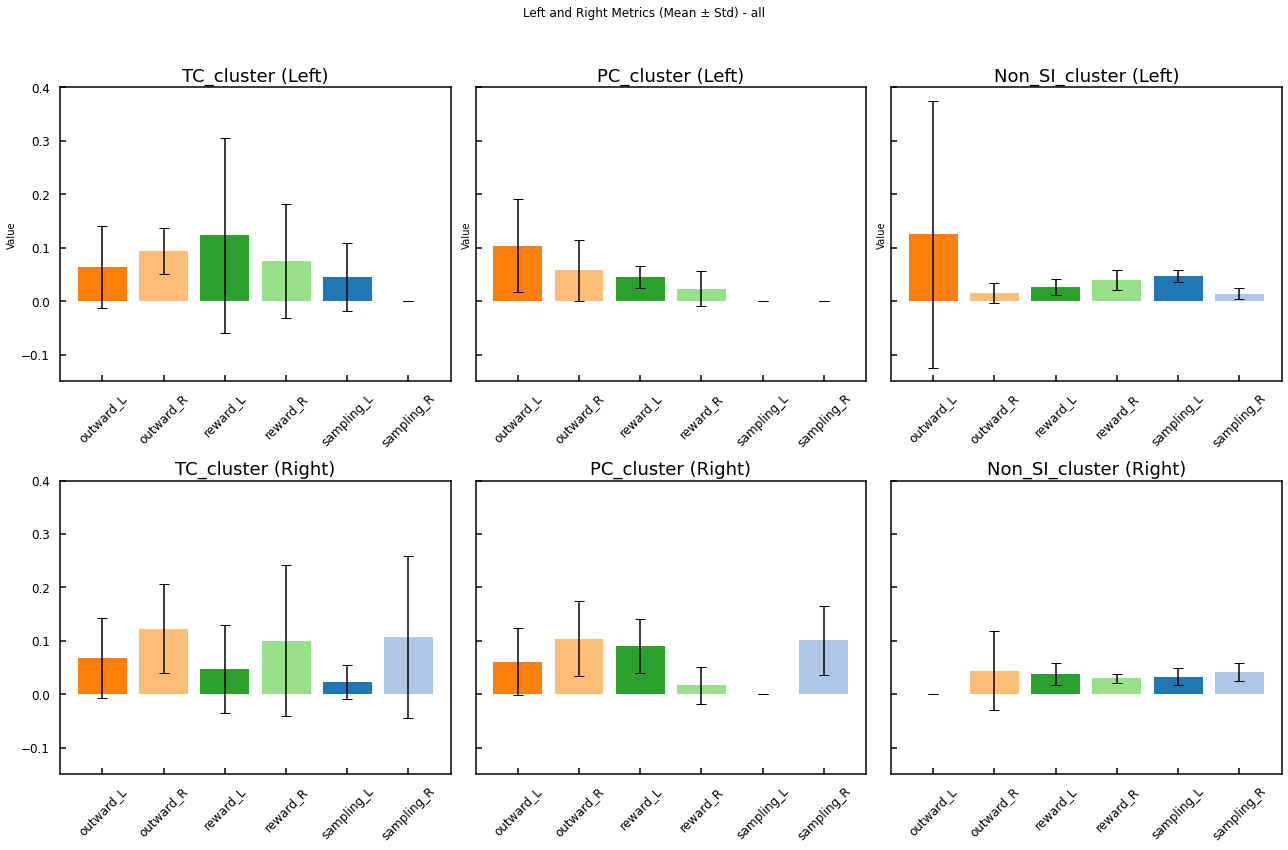

C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15796\3435707698.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickl

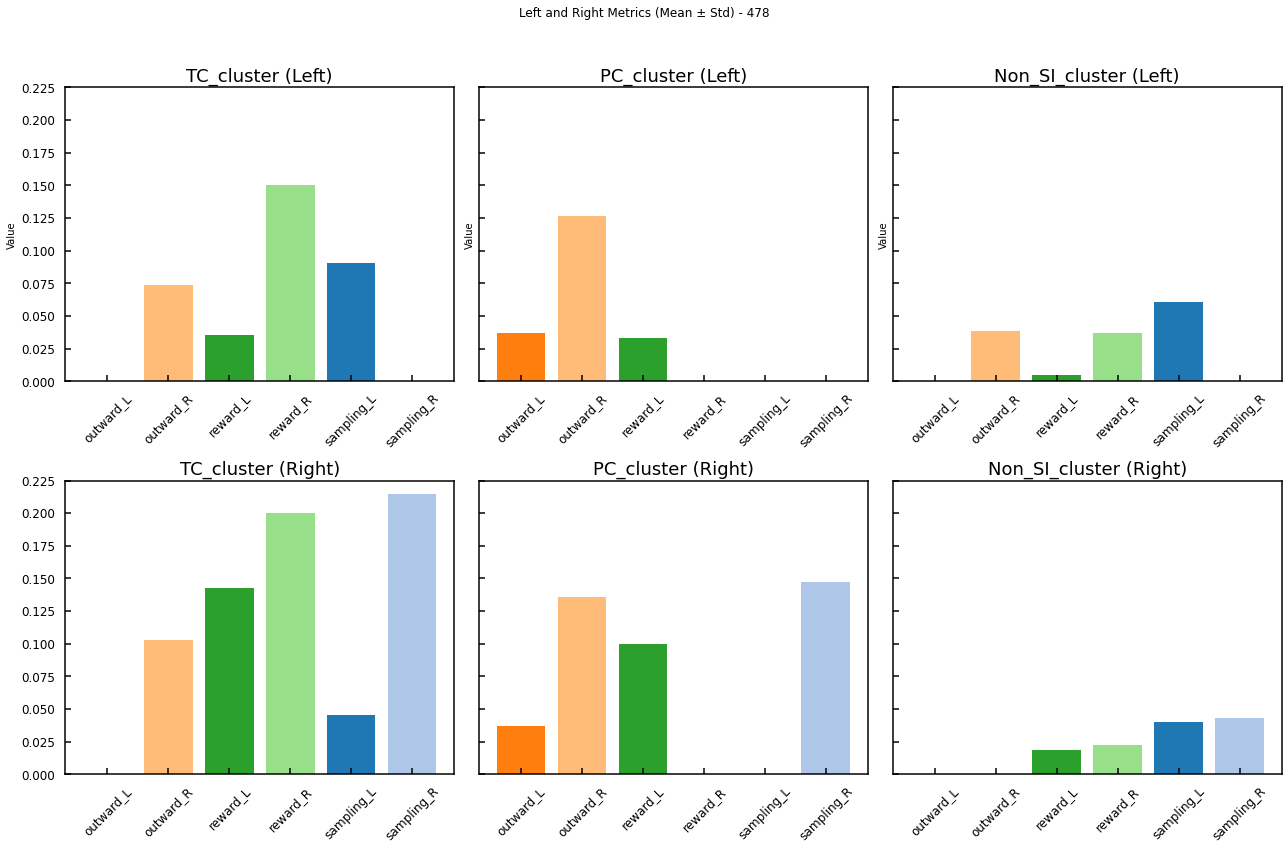

: 

: 

In [ ]:

# Function to process animal data into a DataFrame
def process_animal_data(data):
    all_data = []
    if isinstance(data, dict):
        for animal, values in data.items():
            all_data.extend(values)
        animal_name = 'all'
    elif isinstance(data, list):
        all_data.extend(data)
        animal_name = 'single'
    return pd.DataFrame(all_data, columns=['Cluster', 'Direction', 'Metric', 'Value']), animal_name

# Function to plot bar charts with error bars
def plot_data(df, animal_name, significant_pairs=None):
    agg_data = df.groupby(['Cluster', 'Direction', 'Metric']).agg(['mean', 'std']).reset_index()
    agg_data.columns = ['Cluster', 'Direction', 'Metric', 'Mean', 'Std']

    colors = {
        'sampling_L': '#1f77b4',  # Dark blue
        'sampling_R': '#aec7e8',  # Light blue
        'outward_L': '#ff7f0e',   # Dark orange
        'outward_R': '#ffbb78',   # Light orange
        'reward_L': '#2ca02c',    # Dark green
        'reward_R': '#98df8a',    # Light green
    }

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

    for ax, cluster in zip(axes[0], ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']):
        cluster_data = agg_data[(agg_data['Cluster'] == cluster) & (agg_data['Direction'] == 'left')]
        for metric in cluster_data['Metric'].unique():
            metric_data = cluster_data[cluster_data['Metric'] == metric]
            ax.bar(
                metric,
                metric_data['Mean'].values[0],
                yerr=metric_data['Std'].values[0],
                color=colors.get(metric, '#333333'),
                capsize=5
            )
        ax.set_title(f'{cluster} (Left)')
        ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)
        ax.set_ylabel('Value')

    for ax, cluster in zip(axes[1], ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']):
        cluster_data = agg_data[(agg_data['Cluster'] == cluster) & (agg_data['Direction'] == 'right')]
        for metric in cluster_data['Metric'].unique():
            metric_data = cluster_data[cluster_data['Metric'] == metric]
            ax.bar(
                metric,
                metric_data['Mean'].values[0],
                yerr=metric_data['Std'].values[0],
                color=colors.get(metric, '#333333'),
                capsize=5
            )
        ax.set_title(f'{cluster} (Right)')
        ax.set_xticklabels(cluster_data['Metric'].unique(), rotation=45)

    # Add significance stars if provided
    if significant_pairs:
        for pair in significant_pairs:
            cluster1, cluster2 = pair
            ax = axes[0][0]  # Example: add stars to the first subplot
            y, h, col = agg_data['Mean'].max() + 0.05, 0.02, 'k'
            ax.plot([cluster1, cluster2], [y, y], lw=1.5, c=col)
            ax.text((cluster1 + cluster2) * .5, y + h, '*', ha='center', va='bottom', color=col)

    fig.suptitle(f'Left and Right Metrics (Mean ± Std) - {animal_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Function to perform Kruskal-Wallis test between clusters and return significant pairs
def perform_kruskal(df):
    df = df.dropna(subset=['Value'])
    clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']
    values = {cluster: df[df['Cluster'] == cluster]['Value'].dropna().values for cluster in clusters}

    # Check if any group is empty
    non_empty_values = {k: v for k, v in values.items() if len(v) > 0}
    if len(non_empty_values) < 2:
        print("Kruskal-Wallis Test cannot be performed: Not enough non-empty groups.")
        return []

    h_stat, p_value = kruskal(*non_empty_values.values())
    print("Kruskal-Wallis Test Results:")
    print(f"H-statistic: {h_stat:.4f}")
    print(f"p-value: {p_value:.4e}")

    # Pairwise comparisons with verbose output
    significant_pairs = []
    for cluster1, cluster2 in combinations(non_empty_values.keys(), 2):
        cluster1_values = non_empty_values[cluster1]
        cluster2_values = non_empty_values[cluster2]
        stat, p = kruskal(cluster1_values, cluster2_values)
        print(f"Comparing {cluster1} vs {cluster2}: p-value = {p:.4e}")
        if p < 0.05:
            significant_pairs.append((cluster1, cluster2))

    return significant_pairs

# Example usage
# Process and plot aggregated data
df_all, animal_name = process_animal_data(animal_sig_burst_ratio)
significant_pairs = perform_kruskal(df_all)
plot_data(df_all, animal_name, significant_pairs)

# Process and plot data for a single animal
animal_sig_burst_ratio_anm = animal_sig_burst_ratio['478']
df_single, animal_name = process_animal_data(animal_sig_burst_ratio_anm)
plot_data(df_single, '478')


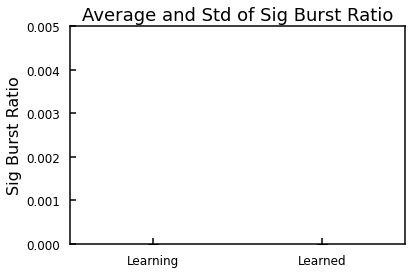

: 

: 

In [67]:
replay_stats={'learning':{},'learned':{}}
animal_list=['478','481','483','485']
for phase in ['learning','learned']:
    for aniaml in animal_list:
        for dir in ['L','R']:
            if aniaml+dir+phase=='483Rlearning':# no data
                continue
            loadfile=savefolder+aniaml+'reward_'+dir+'_'+phase+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_replay'

            replay_stats[phase][aniaml+'_'+dir]=np.load(loadfile,allow_pickle=True)



# Extract sig_burst_ratio values
learning_ratios = [v['sig_burst_ratio'] for v in replay_stats['learning'].values()]
learned_ratios = [v['sig_burst_ratio'] for v in replay_stats['learned'].values()]

# Calculate mean and standard deviation
learning_mean = np.mean(learning_ratios)
learning_std = np.std(learning_ratios)
learned_mean = np.mean(learned_ratios)
learned_std = np.std(learned_ratios)

# Bar plot
labels = ['Learning', 'Learned']
means = [learning_mean, learned_mean]
stds = [learning_std, learned_std]
plt.ylim([0,.005])
plt.bar(labels, means, yerr=stds, capsize=5, color=['blue', 'orange'])
plt.ylabel('Sig Burst Ratio')
plt.title('Average and Std of Sig Burst Ratio')
plt.show()


# ratio=([replay_stats[x]['sig_burst_ratio'] for x in replay_stats.keys()])

# lnb=([x for x in replay_stats.keys()])

# plt.bar(lnb,ratio)
# plt.ylabel('ratio')
# plt.xticks(fontsize=12)
# plt.title('Ratio of signficant replays '+phase)